#  Make draws form arb dist

In [3]:
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
# from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import tqdm
import pandas as pd

%matplotlib inline

# %load_ext version_information

# %version_information pymc3, scipy



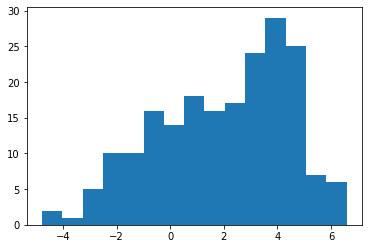

In [6]:
np.random.seed(8675309)
x = stats.norm.rvs(loc=0, scale=2, size=100)
x = np.append(x, stats.norm.rvs(loc=4, scale=1, size=100))
plt.hist(x, 15, density=False);


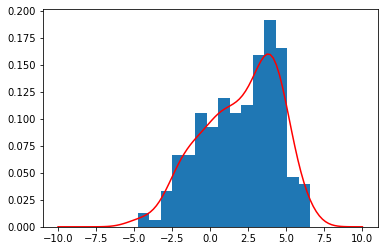

In [8]:
# fit a gaussian kde
kde = stats.gaussian_kde(x)

xx = np.linspace(-10,10, 100)
plt.hist(x, 15, density=True);
plt.plot(xx, kde.evaluate(xx), c='r')


## Brute force draw

In [9]:
def brute_force_draw(kde, xlim=(-10, 10), ylim=(0.0,.2), N=1000):
    samp = []
    while len(samp) < N:
        x = np.random.uniform(xlim[0], xlim[1], size=N*2)
        y = np.random.uniform(ylim[0], ylim[1], size=N*2)
        ind = kde.evaluate(x) >= y
        samp.extend(x[ind])
    samp = samp[:N]
    return  np.asarray(samp)



a = brute_force_draw(kde, N=30)
a, a.shape

(array([ 1.44720382, -1.71361794,  3.86976315,  3.25491413,  5.01536899,
        -3.92613852,  3.07717371, -2.58155544,  3.96060607,  2.58600679,
         4.76246047,  4.77344481, -1.73908732,  4.4657481 ,  5.46449549,
         1.34482137, -1.78096746, -0.95476455,  3.82152142,  3.42466047,
        -2.92877988, -0.49875371,  1.46424991,  0.01999758, -0.2549366 ,
         1.05183601,  1.93340442,  4.04922727,  4.57114483,  5.08852731]),
 (30,))

In [13]:
%timeit brute_force_draw(kde, N=10) 
%timeit brute_force_draw(kde, N=100)
%timeit brute_force_draw(kde, N=1000)
# %timeit brute_force_draw(kde, N=10000)


368 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.12 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.8 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(array([0.0002801 , 0.00233415, 0.00644225, 0.01437836, 0.03753312,
        0.06292866, 0.08823084, 0.1023291 , 0.11390648, 0.12249615,
        0.15358702, 0.13902192, 0.06769033, 0.01885993, 0.00364127]),
 array([-7.68607324, -6.61501916, -5.54396508, -4.47291099, -3.40185691,
        -2.33080282, -1.25974874, -0.18869465,  0.88235943,  1.95341352,
         3.0244676 ,  4.09552169,  5.16657577,  6.23762985,  7.30868394,
         8.37973802]),
 <BarContainer object of 15 artists>)

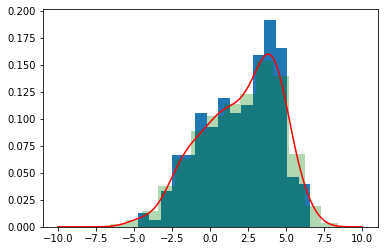

In [15]:
plt.hist(x, 15, density=True);
plt.plot(xx, kde.evaluate(xx), c='r')
plt.hist(brute_force_draw(kde, N=10000), 15, color='g', density=True, alpha=0.3)

# Do this in pymc3

In [16]:
def from_hist(param, kde, xlim=(-10,10), N=100):
    width = xlim[1] - xlim[0]
    x = np.linspace(xlim[0], xlim[1], N)
    y = kde.evaluate(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [17]:
model = Model()
with model:
    # Priors are posteriors from previous iteration
    dat = from_hist('dat', kde)

    # draw 10000 posterior samples
    trace = sample(10000)


/tmp/ipykernel_903/1469286940.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dat]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


/tmp/ipykernel_903/1778458073.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/home/balarsen/miniconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'dat'}>,
        <AxesSubplot:title={'center':'dat'}>]], dtype=object)

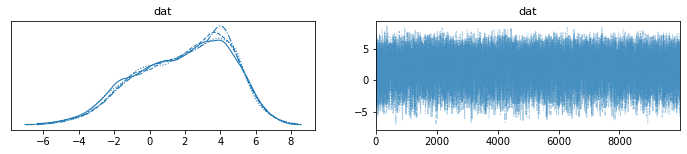

In [18]:
traceplot(trace)

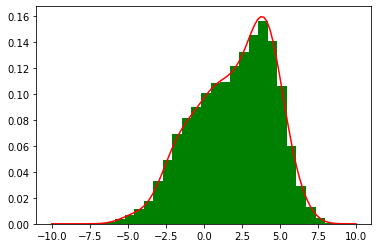

In [20]:
plt.plot(xx, kde.evaluate(xx), c='r')
plt.hist(trace['dat'], 25, density=True, color='g');

# For the heck of it benchmark the brute_force_draw()

In [95]:
df = pd.DataFrame({'iter':[], 'time':[]})

In [101]:
import time
for _ in range(10):
    for i in np.logspace(2, 6, 15).astype(int):
        t0 = time.time()
        brute_force_draw(kde, N=i)
        t = time.time() - t0
        df = df.append({'iter':i, 'time':t}, ignore_index=True)


In [102]:
df.head()

,iter,time
0,100.0,0.028157
1,163.0,0.013186
2,268.0,0.013011
3,439.0,0.022207
4,719.0,0.017751


In [103]:
df.groupby('iter').mean()

,time
iter,
100.0,0.015709
163.0,0.016071
193.0,0.013737
268.0,0.018810
372.0,0.018922
439.0,0.019284
719.0,0.023510
1178.0,0.029916
1389.0,0.031592


RuntimeError: xdata and ydata must be the same length

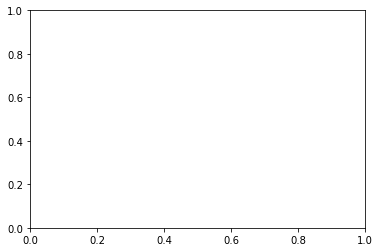

In [104]:
plt.errorbar(np.logspace(2, 6, 15).astype(int), df.groupby('iter').mean().as_matrix(), 
             yerr=df.groupby('iter').std().as_matrix())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('Time [s]')


In [ ]:
df.groupby('iter').std().as_matrix()